In [36]:
import pickle
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

import classification_metrics

%matplotlib inline

In [4]:
# load data
articles = pickle.load(open('articles_df.pickle', 'rb'))
articles_cv = pickle.load(open('articles_doc_term_CV.pickle', 'rb'))
articles_tfidf = pickle.load(open('articles_doc_term_TFIDF.pickle', 'rb'))

In [5]:
# split the TF-IDF document-term matrix into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(articles_tfidf, articles['spam'], test_size = 0.2, 
                                                    random_state = 2, stratify = articles['spam'])

In [6]:
# split the Count Vectorizer document-term matrix into train and test sets (80-20 split)
X_train2, X_test2, y_train2, y_test2 = train_test_split(articles_cv, articles['spam'], test_size = 0.2, 
                                                        random_state = 2, stratify = articles['spam'])

In [7]:
# fit a Gaussian Naive Bayes classification model to the TF-IDF data and assess its performance
NB1 = GaussianNB().fit(X_train, y_train)
NB1_metrics = classification_metrics.compute_metrics(NB1, X_test, y_test)
NB1_metrics

{'accuracy': 0.8661417322834646,
 'f1_score': 0.679245283018868,
 'precision': 0.9473684210526315,
 'recall': 0.5294117647058824,
 'specificity': 0.989247311827957,
 'log_loss': 4.623300777271509,
 'auc': 0.7593295382669196}

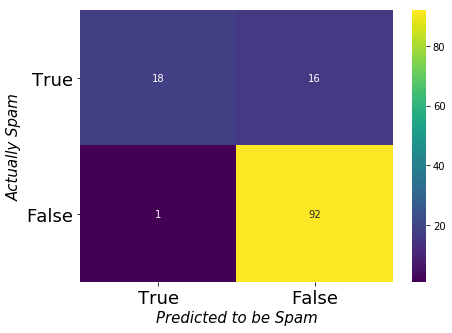

In [8]:
# confusion matrix for Naive Bayes model - only detected half of the spam articles
NB1_cm = confusion_matrix(y_test, NB1.predict(X_test), labels = [True, False])
classification_metrics.print_confusion_matrix(NB1_cm, [True, False])

{'accuracy': 0.937007874015748,
 'auc': 0.9965211891208096,
 'f1_score': 0.8666666666666666,
 'log_loss': 0.14910003007240663,
 'precision': 1.0,
 'recall': 0.7647058823529411,
 'specificity': 1.0}


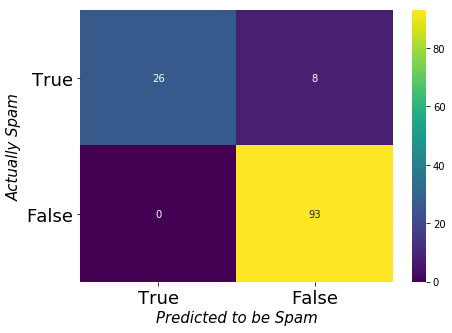

In [9]:
# Assume a multinomial distribution for the predictors instead and fit a Naive Bayes model
# does better than the Gaussian NB model but still only gets ~75% of the spam articles
NB2 = MultinomialNB().fit(X_train, y_train)
NB2_metrics = classification_metrics.compute_metrics(NB2, X_test, y_test)
pprint(NB2_metrics)
NB2_cm = confusion_matrix(y_test, NB2.predict(X_test), labels = [True, False])
classification_metrics.print_confusion_matrix(NB2_cm, [True, False])  

{'accuracy': 0.8661417322834646,
 'auc': 0.7593295382669196,
 'f1_score': 0.679245283018868,
 'log_loss': 4.623300777271509,
 'precision': 0.9473684210526315,
 'recall': 0.5294117647058824,
 'specificity': 0.989247311827957}


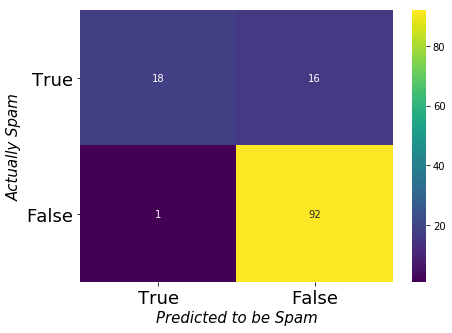

In [10]:
# try Gaussian Naive Bayes on the Count Vectorizer dataset - still misses half of the spam articles
NB3 = GaussianNB().fit(X_train2, y_train2)
NB3_metrics = classification_metrics.compute_metrics(NB3, X_test2, y_test2)
pprint(NB3_metrics)
NB3_cm = confusion_matrix(y_test2, NB3.predict(X_test2), labels = [True, False])
classification_metrics.print_confusion_matrix(NB3_cm, [True, False])

{'accuracy': 0.9921259842519685,
 'auc': 0.9971537001897534,
 'f1_score': 0.9850746268656716,
 'log_loss': 0.2719624324212599,
 'precision': 1.0,
 'recall': 0.9705882352941176,
 'specificity': 1.0}


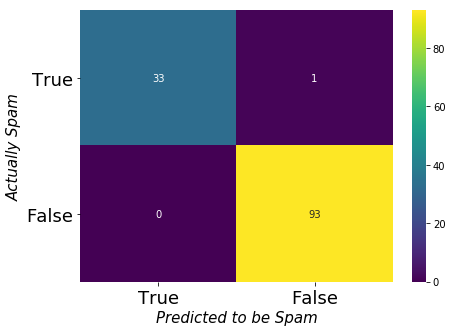

In [11]:
# Multinomial Naive Bayes only misses one article with this dataset!
NB4 = MultinomialNB().fit(X_train2, y_train2)
NB4_metrics = classification_metrics.compute_metrics(NB4, X_test2, y_test2)
pprint(NB4_metrics)
NB4_cm = confusion_matrix(y_test2, NB4.predict(X_test2), labels = [True, False])
classification_metrics.print_confusion_matrix(NB4_cm, [True, False], file = 'NB_cm_80-20.png')

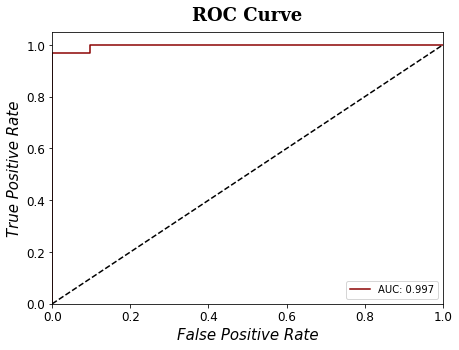

In [12]:
# ROC curve shows nearly perfect fit
classification_metrics.print_roc_curve(NB4, X_test2, y_test2, file = 'NB_ROC_80-20.png')

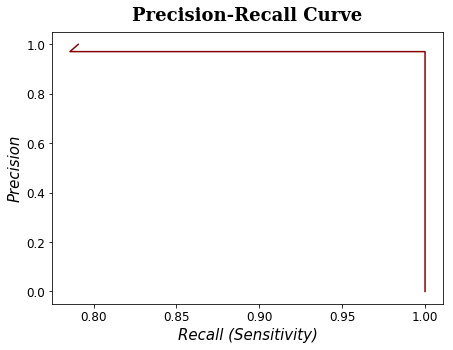

In [13]:
# as does the precision-recall curve
classification_metrics.print_precision_recall_curve(NB4, X_test2, y_test2, file = 'NB_prec_rec_80-20.png')

In [14]:
# what was the article that was incorrectly classified?
articles.iloc[X_test2[y_test2 != NB4.predict(X_test2)].index.tolist(), :].text.values

array(['propertyup barrington excited announce new research tool help buyers and sellers northern illinois get feel for the real estate market    knowing when buy sell  and what expect any given time real estate important having the most successful experience   explained john herman  broker owner propertyup update figures monthly that information always current  when change coming can see the trends ahead time    understanding the real estate market and how fast some cases slowly  properties are selling one the keys success for any buyer seller   the new report shows glance whether the specific markets northern illinois are favoring sellers  balanced favoring buyers   the information relayed easy understand labels via clickable map the area click any label will identify the specific market and define how many months supply inventory avaialble   the information also displayed easy navigate list  with alphabetical selection for those that would rather see information laid out this way ad

In [15]:
# try the smaller training set used for PCA (50-50 train-test split) to see if classifier performs equally well
X_train3, X_test3, y_train3, y_test3 = train_test_split(articles_cv, articles['spam'], test_size = 0.5, 
                                                        random_state = 2, stratify = articles['spam'])

{'accuracy': 0.9873417721518988,
 'auc': 0.992816091954023,
 'f1_score': 0.9759036144578312,
 'log_loss': 0.34688539097458665,
 'precision': 0.9878048780487805,
 'recall': 0.9642857142857143,
 'specificity': 0.9956896551724138}


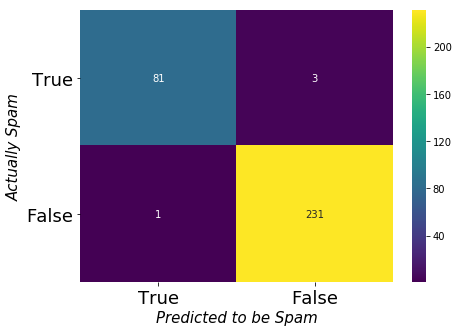

In [16]:
# Multinomial Naive Bayes fit to the new Count Vectorizer dataset (50-50 training-test split)
# does not perform quite as well with less training data
NB5 = MultinomialNB().fit(X_train3, y_train3)
NB5_metrics = classification_metrics.compute_metrics(NB5, X_test3, y_test3)
pprint(NB5_metrics)
NB5_cm = confusion_matrix(y_test3, NB5.predict(X_test3), labels = [True, False])
classification_metrics.print_confusion_matrix(NB5_cm, [True, False], file = 'NB_cm_50-50.png')

In [17]:
k = 5

#Setup k-fold cross-validation method for kNN
kf = KFold(n_splits = k, shuffle = True, random_state = 2)

In [18]:
# use K-fold cross-validation to test different values of k for kNN classifier
k_list = np.arange(1, 21)   # try 20 different values of k
knn_acc = {}
knn_prec = {}
knn_rec = {}

for k in k_list:
    
    # initialize kNN model
    knn = KNeighborsClassifier(n_neighbors = k, n_jobs = -1)
    acc_list = []
    prec_list = []
    rec_list = []
    
    for tr, val in kf.split(X_train3, y_train3):
        
        # split into training and validation sets for each fold
        X_tr, X_val = X_train3.iloc[tr], X_train3.iloc[val]
        y_tr, y_val = y_train3.iloc[tr], y_train3.iloc[val]
        
        #fit kNN model on training set and predict on validation set
        knn.fit(X_tr, y_tr)
        pred = knn.predict(X_val)
        
        #compute accuracy, f1 score, precision, and recall for predictions
        acc_list.append(accuracy_score(y_val, pred))
        prec_list.append(precision_score(y_val, pred))
        rec_list.append(recall_score(y_val, pred))
    
    # take mean of each metric across all 10 folds
    knn_acc[k] = np.mean(acc_list)
    knn_prec[k] = np.mean(prec_list)
    knn_rec[k] = np.mean(rec_list)

In [19]:
# compile results into dataframe with each value of k as columns
pd.DataFrame([knn_acc, knn_prec, knn_rec], index = ['accuracy', 'precision', 'recall'])

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
accuracy,0.955556,0.946032,0.949206,0.942857,0.942857,0.933333,0.933333,0.926984,0.926984,0.920635,0.920635,0.920635,0.920635,0.920635,0.920635,0.920635,0.920635,0.917460,0.917460,0.917460
precision,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
recall,0.843085,0.811924,0.823035,0.800812,0.800812,0.769066,0.769066,0.748014,0.748014,0.724403,0.724403,0.724403,0.724403,0.724403,0.724403,0.724403,0.724403,0.704403,0.704403,0.704403


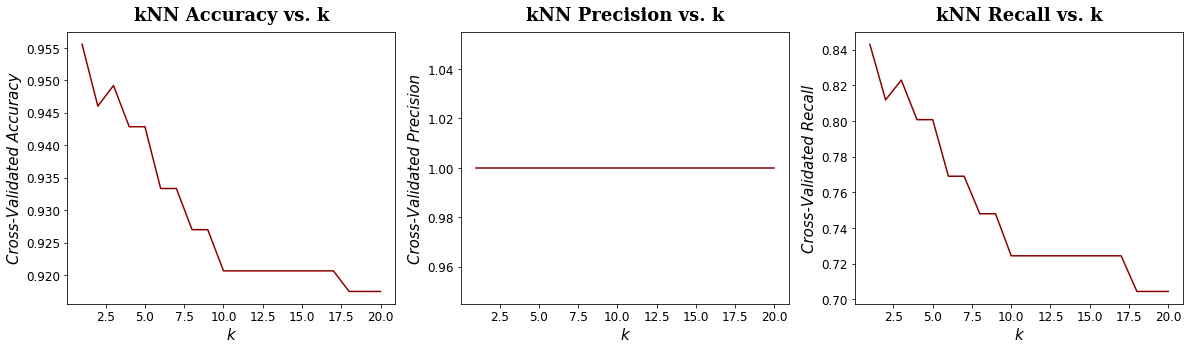

In [20]:
# plot CV accuracy, precision, and recall vs. k
# kNN clearly not a good model for this dataset - heavily overfits the training data (k = 1 seems best)
plt.figure(figsize = (20, 5))

plt.subplot(1, 3, 1)
plt.plot(k_list, list(knn_acc.values()), color = 'darkred')
plt.title("kNN Accuracy vs. k", fontsize = 18, fontweight = 'bold', family = 'serif', y = 1.02)
plt.xlabel('k', style = 'italic', fontsize = 15)
plt.ylabel('Cross-Validated Accuracy', style = 'italic', fontsize = 15)
plt.xticks(fontsize = 12, rotation = 0)
plt.yticks(fontsize = 12)

plt.subplot(1, 3, 2)
plt.plot(k_list, list(knn_prec.values()), color = 'darkred')
plt.title("kNN Precision vs. k", fontsize = 18, fontweight = 'bold', family = 'serif', y = 1.02)
plt.xlabel('k', style = 'italic', fontsize = 15)
plt.ylabel('Cross-Validated Precision', style = 'italic', fontsize = 15)
plt.xticks(fontsize = 12, rotation = 0)
plt.yticks(fontsize = 12)

plt.subplot(1, 3, 3)
plt.plot(k_list, list(knn_rec.values()), color = 'darkred')
plt.title("kNN Recall vs. k", fontsize = 18, fontweight = 'bold', family = 'serif', y = 1.02)
plt.xlabel('k', style = 'italic', fontsize = 15)
plt.ylabel('Cross-Validated Recall', style = 'italic', fontsize = 15)
plt.xticks(fontsize = 12, rotation = 0)
plt.yticks(fontsize = 12)

plt.savefig('knn_objects_cv.png', dpi = 100, bbox_inches = 'tight')
plt.show()
plt.close()

In [21]:
# load the train and test sets generated from PCA scores
X_train4 = pickle.load(open('PCA_scores_train.pickle', 'rb'))
X_test4 = pickle.load(open('PCA_scores_test.pickle', 'rb'))
y_train4 = pickle.load(open('spam_category_train.pickle', 'rb'))
y_test4 = pickle.load(open('spam_category_test.pickle', 'rb'))

{'accuracy': 0.9493670886075949,
 'auc': 0.9814244663382594,
 'f1_score': 0.9,
 'log_loss': 1.036498413339894,
 'precision': 0.9473684210526315,
 'recall': 0.8571428571428571,
 'specificity': 0.9827586206896551}


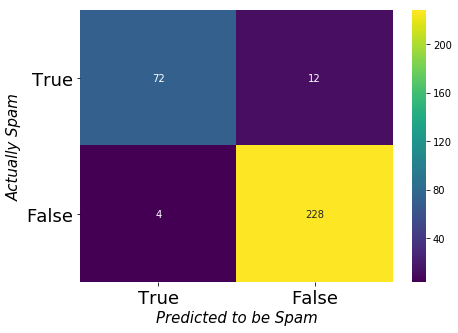

In [22]:
# try fitting Gaussian Naive Bayes to the PC scores dataset
# does better than Gaussian NB on raw data but still not as good as Multinomial NB on the raw counts
NB6 = GaussianNB().fit(X_train4, y_train4)
NB6_metrics = classification_metrics.compute_metrics(NB6, X_test4, y_test4)
pprint(NB6_metrics)
NB6_cm = confusion_matrix(y_test4, NB6.predict(X_test4), labels = [True, False])
classification_metrics.print_confusion_matrix(NB6_cm, [True, False])

{'accuracy': 0.990506329113924,
 'auc': 0.9961514778325122,
 'f1_score': 0.9818181818181818,
 'log_loss': 0.04660047829887527,
 'precision': 1.0,
 'recall': 0.9642857142857143,
 'specificity': 1.0}


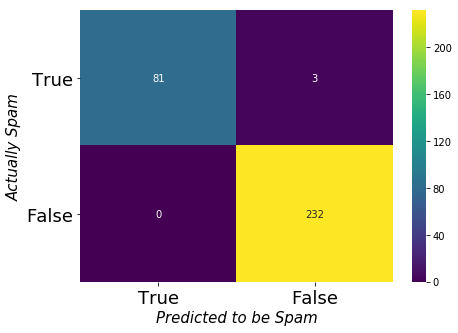

In [23]:
# fit logistic regression model on the 50-50 train-test split of the raw count data (Count Vectorizer)
logistic1 = LogisticRegression(solver = 'liblinear').fit(X_train3, y_train3)
logistic1_metrics = classification_metrics.compute_metrics(logistic1, X_test3, y_test3)
pprint(logistic1_metrics)
logistic1_cm = confusion_matrix(y_test3, logistic1.predict(X_test3), labels = [True, False])
classification_metrics.print_confusion_matrix(logistic1_cm, [True, False])

In [24]:
# which spam articles did it miss?
articles.iloc[X_test3[y_test3 != logistic1.predict(X_test3)].index.tolist(), :]

,text,link,spam
509,propertyup barrington excited announce new res...,https://www.satprnews.com/2018/03/25/property-...,True
506,two major campaigns are running now fund save...,https://www.satprnews.com/2018/03/25/donate-to...,True
508,groundless claims from nacc namibian competit...,https://www.satprnews.com/2018/03/25/baiting-o...,True


In [25]:
# show the text from those missed articles to see if any patterns stand out
articles.iloc[X_test3[y_test3 != logistic1.predict(X_test3)].index.tolist(), :].text.values

array(['propertyup barrington excited announce new research tool help buyers and sellers northern illinois get feel for the real estate market    knowing when buy sell  and what expect any given time real estate important having the most successful experience   explained john herman  broker owner propertyup update figures monthly that information always current  when change coming can see the trends ahead time    understanding the real estate market and how fast some cases slowly  properties are selling one the keys success for any buyer seller   the new report shows glance whether the specific markets northern illinois are favoring sellers  balanced favoring buyers   the information relayed easy understand labels via clickable map the area click any label will identify the specific market and define how many months supply inventory avaialble   the information also displayed easy navigate list  with alphabetical selection for those that would rather see information laid out this way ad

{'accuracy': 0.9810126582278481,
 'auc': 0.9976395730706076,
 'f1_score': 0.963855421686747,
 'log_loss': 0.09182672438007276,
 'precision': 0.975609756097561,
 'recall': 0.9523809523809523,
 'specificity': 0.9913793103448276}


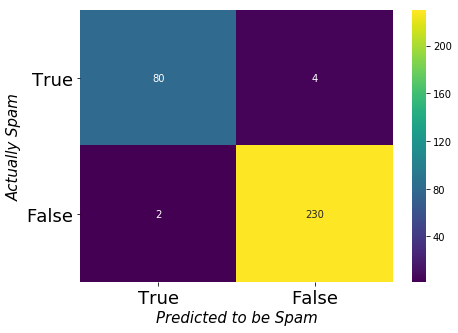

In [26]:
# try logistic regression on the PC scores (does not perform as well)
logistic2 = LogisticRegression(solver = 'liblinear').fit(X_train4, y_train4)
logistic2_metrics = classification_metrics.compute_metrics(logistic2, X_test4, y_test4)
pprint(logistic2_metrics)
logistic2_cm = confusion_matrix(y_test4, logistic2.predict(X_test4), labels = [True, False])
classification_metrics.print_confusion_matrix(logistic2_cm, [True, False])

In [27]:
# which articles did it miss?
articles.iloc[X_test3[y_test4 != logistic2.predict(X_test4)].index.tolist(), :]

,text,link,spam
383,biodiversity the essential variety life for...,https://www.sciencedaily.com/releases/2018/03/...,False
509,propertyup barrington excited announce new res...,https://www.satprnews.com/2018/03/25/property-...,True
462,the business selling legal weed big and gettin...,https://fivethirtyeight.com/features/legal-wee...,False
492,server virtualization transcription multiple s...,https://www.satprnews.com/2018/03/25/server-vi...,True
506,two major campaigns are running now fund save...,https://www.satprnews.com/2018/03/25/donate-to...,True
508,groundless claims from nacc namibian competit...,https://www.satprnews.com/2018/03/25/baiting-o...,True


In [28]:
# fit random forest classifier to the data
# start by using grid search with cross-validation to identify the best hyperparameter values to use
RF = RandomForestClassifier(n_jobs = -1, random_state = 2, n_estimators = 100)
param_grid = dict(min_samples_split = [2, 5, 10, 25], 
                  max_features = [100, 150, 200, None], 
                  bootstrap = [True, False]
                 )

RF_grid = GridSearchCV(RF, param_grid, scoring = 'recall', n_jobs = -1, cv = 5)  #using recall due to imbalance
RF_grid.fit(X_train3, y_train3)

print(RF_grid.best_score_)
print(RF_grid.best_params_) 

1.0
{'bootstrap': True, 'max_features': 200, 'min_samples_split': 5}


{'accuracy': 0.9968354430379747,
 'auc': 0.9938423645320198,
 'f1_score': 0.9940119760479043,
 'log_loss': 0.1105850830683063,
 'precision': 1.0,
 'recall': 0.9880952380952381,
 'specificity': 1.0}


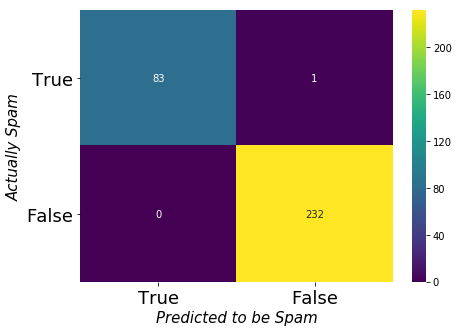

In [29]:
# fit random forest classifier to whole training set with optimal parameters - only misses one article!
RF = RandomForestClassifier(n_estimators = 500,  
                            min_samples_split = 5, 
                            bootstrap = True, 
                            max_features = None,
                            n_jobs = -1, 
                            random_state = 2
                           )

RF.fit(X_train3, y_train3)
RF_metrics = classification_metrics.compute_metrics(RF, X_test3, y_test3)
pprint(RF_metrics)
RF_cm = confusion_matrix(y_test3, RF.predict(X_test3), labels = [True, False])
classification_metrics.print_confusion_matrix(RF_cm, [True, False], file = 'RF_cm_best.png')

In [30]:
# which article did it miss?
articles.iloc[X_test3[y_test3 != RF.predict(X_test3)].index.tolist(), :].text.values

array(['propertyup barrington excited announce new research tool help buyers and sellers northern illinois get feel for the real estate market    knowing when buy sell  and what expect any given time real estate important having the most successful experience   explained john herman  broker owner propertyup update figures monthly that information always current  when change coming can see the trends ahead time    understanding the real estate market and how fast some cases slowly  properties are selling one the keys success for any buyer seller   the new report shows glance whether the specific markets northern illinois are favoring sellers  balanced favoring buyers   the information relayed easy understand labels via clickable map the area click any label will identify the specific market and define how many months supply inventory avaialble   the information also displayed easy navigate list  with alphabetical selection for those that would rather see information laid out this way ad

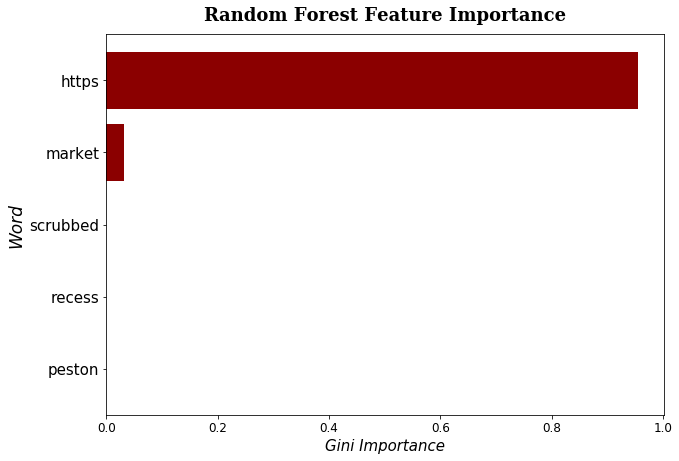

In [31]:
# barplot of Gini importances for top predictors from random forest model
feature_imp_rf = pd.DataFrame({'features': X_train3.columns, 'importance': RF.feature_importances_})\
                    .sort_values('importance', ascending = True)[-5:]

plt.figure(figsize = (10, 7))
plt.barh(feature_imp_rf['features'], feature_imp_rf['importance'], color = 'darkred')
plt.title("Random Forest Feature Importance", fontsize = 18, 
          fontweight = 'bold', family = 'serif', y = 1.02)
plt.xlabel("Gini Importance", fontsize = 15, style = 'italic')
plt.ylabel("Word", fontsize = 17, style = 'italic')
plt.xticks(fontsize = 12, rotation = 0)
plt.yticks(fontsize = 15)

plt.savefig('rf_feature_importance.png', dpi = 100, bbox_inches = 'tight')
plt.show()
plt.close()

In [32]:
# generate image of first decision tree from random forest
tree.export_graphviz(RF.estimators_[1], out_file = 'tree.dot', filled = True, label = 'none', 
                     feature_names = X_train3.columns.tolist(), impurity = False, proportion = True)

!dot -Tpng tree.dot -o tree.png

![tree](img/tree.png)

In [33]:
# try random forest on PCs scores dataset - start with grid search again for hyperparameter optimization
RF2 = RandomForestClassifier(n_jobs = -1, random_state = 2, n_estimators = 100)
param_grid = dict(min_samples_split = [2, 5, 10, 25], 
                  max_features = [2, 5, 10, 25], 
                  bootstrap = [True, False]
                 )

RF2_grid = GridSearchCV(RF2, param_grid, scoring = 'recall', n_jobs = -1, cv = 5)
RF2_grid.fit(X_train4, y_train4)

print(RF2_grid.best_score_)
print(RF2_grid.best_params_)

0.9762838468720823
{'bootstrap': False, 'max_features': 5, 'min_samples_split': 5}


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'accuracy': 0.9651898734177216,
 'auc': 0.9743944991789819,
 'f1_score': 0.9299363057324841,
 'log_loss': 0.16715496260087867,
 'precision': 1.0,
 'recall': 0.8690476190476191,
 'specificity': 1.0}


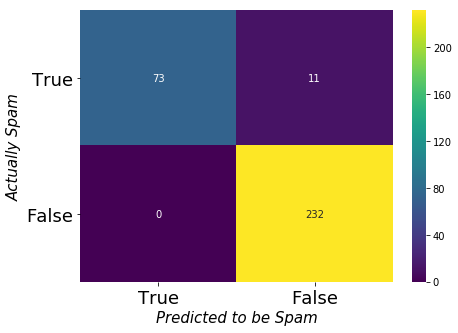

In [34]:
# fit random forest classifier to whole PC scores training set with optimal parameters - performs poorly
RF2 = RandomForestClassifier(n_estimators = 500,  
                            min_samples_split = 5, 
                            bootstrap = False,
                            max_features = 5,
                            n_jobs = -1, 
                            random_state = 2
                           )

RF2.fit(X_train4, y_train4)
RF2_metrics = classification_metrics.compute_metrics(RF2, X_test4, y_test4)
pprint(RF2_metrics)
RF2_cm = confusion_matrix(y_test4, RF2.predict(X_test4), labels = [True, False])
classification_metrics.print_confusion_matrix(RF2_cm, [True, False])

In [37]:
# reload the original data file
data = json.load(open('data/scraped_articles.json', 'r'))

In [38]:
# extract raw article text (non-cleaned) from original input file
article_text_raw = []
for src in data['newspapers'].keys():
    for article in data['newspapers'][src]['articles']:
        article_text_raw.append(article['text'])
print(article_text_raw[501])

Wireless technology that transmits digital data over a wide range of frequency bands is known to be ultra-wideband. These bands utilizes very less power for a short distance. Radios which are ultra-wideband technology enabled have the capacity to transmit huge amount of data as well as signals through the doors and other obstacles. Ultra wideband programs digital pulses which are timed very accurately on a carrier signal across a wide spectrum. In ultra-wideband accuracy needs to be maintained, to send and receive pulses through the coordination of transmitter and receiver.

Ultra wideband has two prime type of applications that are applications involving radar, and application involving voice and data transmission using data pulses. Ultra wideband is appropriate for short-range and high-speed data transmissions for WPAN applications. Ultra wideband is used in ground penetrating radar and other military communications due to its speed and accuracy in timing.

Global Ultra wideband Mark

In [39]:
# use a regular expression to extract the URLs from each article
url = re.compile(r'((http|https)\:\/\/)?[a-zA-Z0-9\.]+\.([a-zA-Z]){3}(\/[a-zA-Z0-9\.\&\/\?\:@\-_=#])*')
re.findall(url, article_text_raw[501])

[('https://', 'https', 'm', '/s'), ('https://', 'https', 'm', '')]

In [40]:
# find URLs and count them
url_count = []
for article in article_text_raw:
    url_count.append(len(re.findall(url, article)))
print(url_count)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 

In [41]:
# add URL count feature to Count Vectorizer document-term matrix and re-generate the train-test split
articles_cv['url_count'] = url_count

X_train3, X_test3, y_train3, y_test3 = train_test_split(articles_cv, articles['spam'], test_size = 0.5, 
                                                        random_state = 2, stratify = articles['spam'])

{'accuracy': 0.9588607594936709,
 'auc': 0.9334975369458128,
 'f1_score': 0.9182389937106918,
 'log_loss': 0.20831648044307488,
 'precision': 0.9733333333333334,
 'recall': 0.8690476190476191,
 'specificity': 0.9913793103448276}


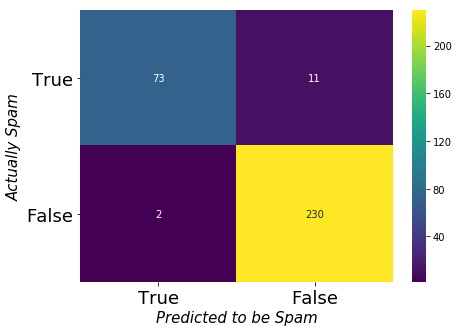

In [42]:
# logistic regression model just based on URL count gets 96% accuracy and 87% recall!
logistic3 = LogisticRegression(solver = 'liblinear').fit(X_train3[['url_count']], y_train3)
logistic3_metrics = classification_metrics.compute_metrics(logistic3, X_test3[['url_count']], y_test3)
pprint(logistic3_metrics)
logistic3_cm = confusion_matrix(y_test3, logistic3.predict(X_test3[['url_count']]), labels = [True, False])
classification_metrics.print_confusion_matrix(logistic3_cm, [True, False], file = 'logistic_url_count.png')

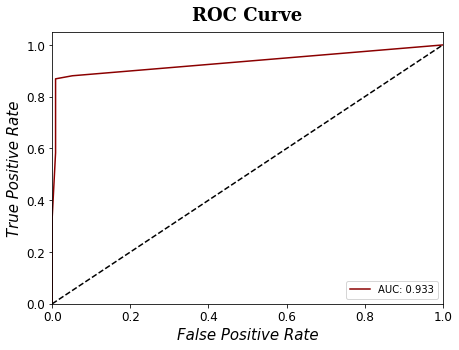

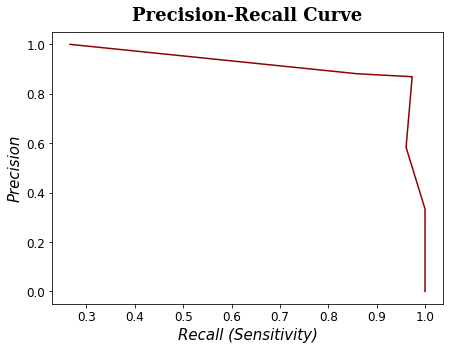

In [43]:
# plot ROC and precision-recall curves for logistic regression model based on URL count only
classification_metrics.print_roc_curve(logistic3, X_test3[['url_count']], y_test3, 
                                       file = 'logistic_ROC_url.png')
classification_metrics.print_precision_recall_curve(logistic3, X_test3[['url_count']], y_test3, 
                                                    file = 'logistic_prec_rec_url.png')

In [44]:
print(logistic3.coef_)  # increase in log-odds of article being spam for every additional link present
print(np.exp(logistic3.coef_))  # odds of article being spam increase almost 5x for every additional link 

[[1.53011223]]
[[4.61869513]]


In [45]:
# use a regular expression to extract the exclamation points from each article and count them
excl_point = re.compile(r'!')
ep_count = []
for article in article_text_raw:
    ep_count.append(len(re.findall(excl_point, article)))
print(ep_count)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 5, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 0, 0, 0, 

In [46]:
# generate a train-test split (50-50) of the exclamation point counts with spam category as response
X_train5, X_test5, y_train5, y_test5 = train_test_split(ep_count, articles['spam'], test_size = 0.5, 
                                                        random_state = 2, stratify = articles['spam'])

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'accuracy': 0.7341772151898734,
 'auc': 0.5378694581280788,
 'f1_score': 0.0,
 'log_loss': 0.5688379926873804,
 'precision': 0.0,
 'recall': 0.0,
 'specificity': 1.0}


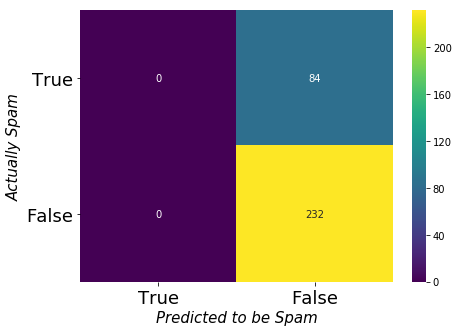

In [47]:
# logistic regression model just based on exclamation points fails to predict any spam articles
logistic4 = LogisticRegression(solver = 'liblinear').fit(np.array(X_train5).reshape(-1, 1), y_train5)
logistic4_metrics = classification_metrics.compute_metrics(logistic4, np.array(X_test5).reshape(-1, 1), y_test5)
pprint(logistic4_metrics)
logistic4_cm = confusion_matrix(y_test5, logistic4.predict(np.array(X_test5).reshape(-1, 1)), 
                                labels = [True, False])
classification_metrics.print_confusion_matrix(logistic4_cm, [True, False], file = 'logistic_ep_count.png')

In [48]:
print(logistic4.coef_)  # decrease in log-odds of article being spam for every additional exclamation point
print(np.exp(logistic4.coef_))  # odds of article being spam decrease by ~70% for each additional excl. point

[[-1.20668291]]
[[0.29918807]]


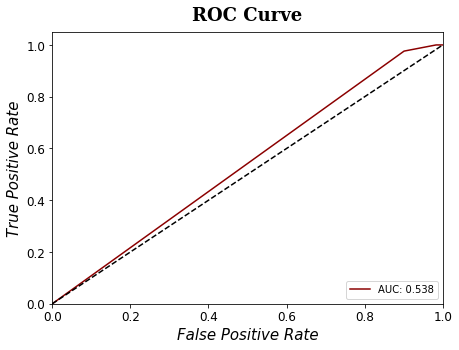

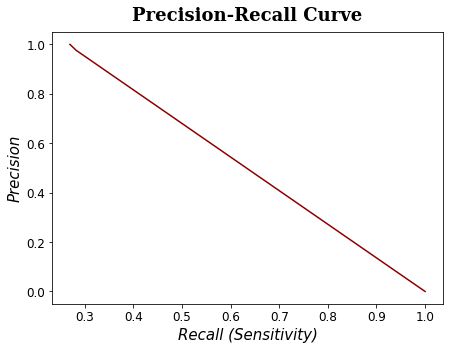

In [49]:
# plot ROC and precision-recall curves for logistic regression exclamation point model
classification_metrics.print_roc_curve(logistic4, np.array(X_test5).reshape(-1, 1), y_test5, 
                                       file = 'logistic_ROC_ep.png')
classification_metrics.print_precision_recall_curve(logistic4, np.array(X_test5).reshape(-1, 1), y_test5, 
                                                    file = 'logistic_prec_rec_ep.png')

{'accuracy': 0.990506329113924,
 'auc': 0.9971264367816093,
 'f1_score': 0.9818181818181818,
 'log_loss': 0.041985653389089286,
 'precision': 1.0,
 'recall': 0.9642857142857143,
 'specificity': 1.0}


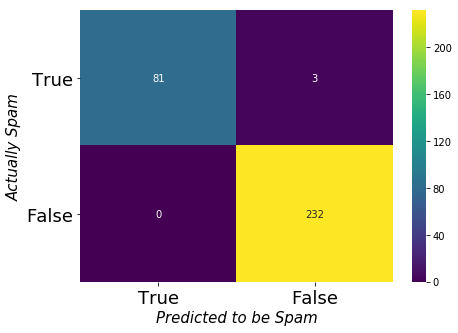

In [50]:
# adding url counts to the full feature set does not improve the original logistic regression model
logistic5 = LogisticRegression(solver = 'liblinear').fit(X_train3, y_train3)
logistic5_metrics = classification_metrics.compute_metrics(logistic5, X_test3, y_test3)
pprint(logistic5_metrics)
logistic5_cm = confusion_matrix(y_test3, logistic5.predict(X_test3), labels = [True, False])
classification_metrics.print_confusion_matrix(logistic5_cm, [True, False], file = 'logistic_best_cm.png')

In [51]:
# still misses the same 3 spam articles as the original logistic regression model
[article_text_raw[i] for i in X_test3[y_test3 != logistic5.predict(X_test3)].index]

['PropertyUp, of Barrington, is excited to announce a new research tool to help buyers and sellers in Northern Illinois to get a feel for the real estate market.\n\n“Knowing when to buy or sell, and what to expect at any given time in real estate is important to having the most successful experience,” explained John Herman, broker/owner of PropertyUp. “We update figures monthly so that information is always current. When a change is coming, we can see the trends ahead of time.”\n\nUnderstanding the real estate market and how fast, or in some cases slowly, properties are selling is one of the keys to success for any buyer or seller.\n\nThe new report shows at a glance whether the specific markets of Northern Illinois are favoring sellers, balanced, or favoring buyers.\n\nThe information is relayed in easy to understand labels via a clickable map of the area. A click on any label will identify the specific market and define how many months supply of inventory is avaialble.\n\nThe informa

In [52]:
# extract coefficients from new logistic regression model to see which features (words) carry the most weight
logit_coef = pd.DataFrame(logistic5.coef_, columns = articles_cv.columns)
print('Positively Correlated with Spam:', '\n\n', 
      logit_coef.iloc[0, :].sort_values(ascending = False)[0:25], '\n')
print('Negatively Correlated with Spam:', '\n\n', 
      logit_coef.iloc[0, :].sort_values(ascending = True)[0:25])

Positively Correlated with Spam: 

 market            0.256303
global            0.160556
report            0.146368
growth            0.113557
https             0.101399
www               0.093228
url_count         0.092072
wireless          0.086149
chemicals         0.084289
transportation    0.080065
management        0.077696
satprnews         0.074787
combustion        0.067286
demand            0.063062
production        0.061137
com               0.057891
solution          0.057093
sample            0.056891
sanitation        0.055437
industry          0.050721
maintenance       0.050614
mining            0.049664
catalysts         0.048936
conveyor          0.046759
various           0.045337
Name: 0, dtype: float64 

Negatively Correlated with Spam: 

 said        -0.420594
like        -0.277478
year        -0.248124
cnbc        -0.209529
new         -0.205724
percent     -0.204179
people      -0.202964
world       -0.195432
years       -0.186783
facebook    -0.176451
week   

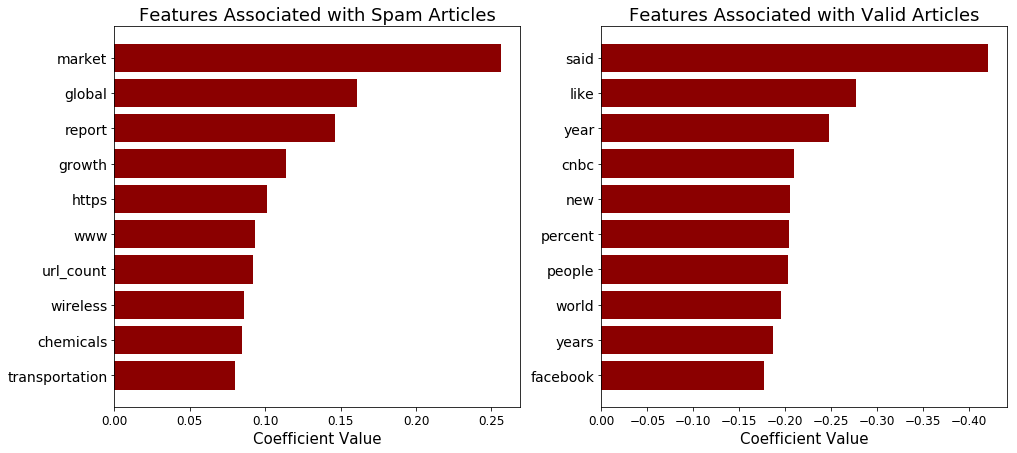

In [53]:
# barplots of most important words identifying spam articles (positive logistic regression coefficients) 
# and valid articles (negative regression coefficients)
plt.figure(figsize = (16, 7))

plt.subplot(1, 2, 1)
plt.barh(logit_coef.iloc[0, :].sort_values(ascending = True).index[-10:], 
         logit_coef.iloc[0, :].sort_values(ascending = True)[-10:], color = 'darkred')
plt.xlabel('Coefficient Value', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 14)
plt.title('Features Associated with Spam Articles', fontsize = 18)

plt.subplot(1, 2, 2)
plt.barh(logit_coef.iloc[0, :].sort_values(ascending = False).index[-10:], 
         logit_coef.iloc[0, :].sort_values(ascending = False)[-10:], color = 'darkred')
plt.xlabel('Coefficient Value', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 14)
plt.gca().invert_xaxis()
plt.title('Features Associated with Valid Articles', fontsize = 18)

plt.savefig('logistic_important_features.png', dpi = 100, bbox_inches = 'tight')
plt.show()
plt.close()